# Binary Classification with the UCI Credit-card Default Dataset
_**Mitigating disparities in accuracy as measured by equalized-odds difference**_

## Contents

1. [What is Covered](#What-is-Covered)
1. [Introduction](#Introduction)
1. [The UCI Credit-card Default Dataset](#The-UCI-Credit-card-Default-Dataset)
1. [Using a Fairness Unaware Model](#Using-a-Fairness-Unaware-Model)
1. [Mitigating Equalized Odds Difference with Postprocessing](#Mitigating-Equalized-Odds-Difference-with-Postprocessing)
1. [Mitigating Equalized Odds Difference with GridSearch](#Mitigating-Equalized-Odds-Difference-with-GridSearch)

## What is Covered

* **Domain:**
  * Finance (loan decisions). The data is semisynthetic to create a simple example of disparity in accuracy.

* **ML task:**
  * Binary classification.

* **Fairness tasks:**
  * Assessment of unfairness using Fairlearn metrics and Fairlearn dashboard.
  * Mitigation of unfairness using Fairlearn mitigation algorithms.

* **Performance metrics:**
  * Area under ROC curve.
  * Balanced accuracy.

* **Fairness metrics:**
  * Equalized-odds difference.

* **Mitigation algorithms:**
  * `fairlearn.reductions.GridSearch`
  * `fairlearn.postprocessing.ThresholdOptimizer`

## Introduction

In this example, we emulate the problem of accuracy disparities arising in loan decisions. Specifically, we consider scenarios where algorithmic tools are trained on historic data and their predictions about loan applicants are used for making decisions about applicants. See [here](https://www.nytimes.com/2019/11/10/business/Apple-credit-card-investigation.html) for an example involving sex-based discrimination for credit limit decisions.  

We use the [UCI dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) on credit-card defaults in 2005 in Taiwan. For the sake of this exercise, we modify the original UCI dataset: we introduce a synthetic feature that has a strong predictive power for female clients, but is uninformative for male applicants. We fit a variety of models for predicting the default of a client. We show that a fairness-unaware training algorithm can lead to a predictor that achieves a much better accuracy for women than for men, and that it is insufficient to simply remove the sensitive feature (in this case sex) from training. We then use Fairlearn to mitigate this disparity in accuracy with either `ThresholdOptimizer` or `GridSearch`. 

In [1]:
import sys
print(sys.path)

# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds
from fairlearn.widget import FairlearnDashboard

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

['C:\\Users\\Mr Saraivinha\\Documents\\GitHub\\fairlearn\\notebooks', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.8_3.8.1776.0_x64__qbz5n2kfra8p0\\python38.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.8_3.8.1776.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.8_3.8.1776.0_x64__qbz5n2kfra8p0\\lib', 'C:\\Users\\Mr Saraivinha\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0', 'c:\\users\\mr saraivinha\\documents\\github\\fairlearn\\.env', '', 'c:\\users\\mr saraivinha\\documents\\github\\fairlearn\\.env\\lib\\site-packages', 'c:\\users\\mr saraivinha\\documents\\github\\fairlearn\\.env\\lib\\site-packages\\win32', 'c:\\users\\mr saraivinha\\documents\\github\\fairlearn\\.env\\lib\\site-packages\\win32\\lib', 'c:\\users\\mr saraivinha\\documents\\github\\fairlearn\\.env\\lib\\site-packages\\Pythonwin', 'c:\\users\\mr saraivinha\\documents\\github\\fai

## The UCI Credit-card Default Dataset

The UCI dataset contains data on 30,000 clients and their credit card transactions at a bank in Taiwan. In addition to static client features, the dataset contains the history of credit card bill payments between April and September 2005, as well as the balance limit of the client's credit card. The target is whether the client will default on a card payment in the following month, October 2005. One can imagine that a model trained on this data can be used in practice to determine whether a client is eligible for another product such as an auto loan. 

In [3]:
# Load the data
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = pd.read_excel(io=data_url, header=1).drop(columns=['ID']).rename(columns={'PAY_0':'PAY_1'})
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Dataset columns:

* `LIMIT_BAL`: credit card limit, will be replaced by a synthetic feature
* `SEX, EDUCATION, MARRIAGE, AGE`: client demographic features
* `BILL_AMT[1-6]`: amount on bill statement for April-September
* `PAY_AMT[1-6]`: payment amount for April-September
* `default payment next month`: target, whether the customer defaulted the following month

In [47]:
# Extract the sensitive feature
A = dataset["SEX"]
A_str = A.map({ 2:"female", 1:"male"})
# Extract the target
Y = dataset["default payment next month"]
categorical_features = ['EDUCATION', 'MARRIAGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in categorical_features:
    dataset[col] = dataset[col].astype('category')

### Introduce a Synthetic Feature

We manipulate the balance-limit feature `LIMIT_BAL` to make it highly predictive for women but not for men. For example, we can imagine that a lower credit limit indicates that a female client is less likely to default, but provides no information on a male client's probability of default.

In [5]:
dist_scale = 0.5
np.random.seed(12345)
# Make 'LIMIT_BAL' informative of the target
dataset['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, size=dataset.shape[0])
# But then make it uninformative for the male clients
dataset.loc[A==1, 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, size=dataset[A==1].shape[0])

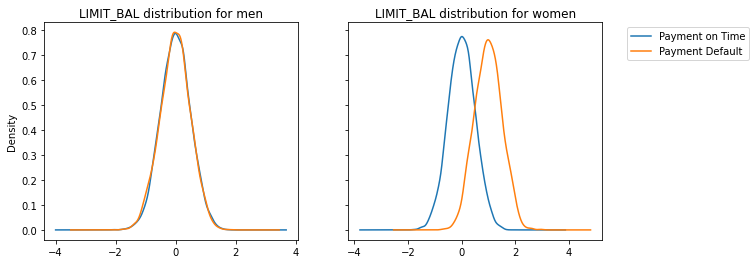

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# Plot distribution of LIMIT_BAL for men
dataset['LIMIT_BAL'][(A==1) & (Y==0)].plot(kind='kde', label="Payment on Time", ax=ax1, 
                                           title="LIMIT_BAL distribution for men")
dataset['LIMIT_BAL'][(A==1) & (Y==1)].plot(kind='kde', label="Payment Default", ax=ax1)
# Plot distribution of LIMIT_BAL for women
dataset['LIMIT_BAL'][(A==2) & (Y==0)].plot(kind='kde', label="Payment on Time", ax=ax2, 
                                           legend=True, title="LIMIT_BAL distribution for women")
dataset['LIMIT_BAL'][(A==2) & (Y==1)].plot(kind='kde', label="Payment Default", ax=ax2, 
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
plt.show()

We notice from the above figures that the new `LIMIT_BAL` feature is indeed highly predictive for women, but not for men.

In [19]:
# Train-test split
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    dataset.drop(columns=['SEX', 'default payment next month']), 
    Y, 
    A, 
    A_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

## Using a Fairness Unaware Model

We train an out-of-the-box `lightgbm` model on the modified data and assess several disparity metrics. 

In [51]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

In [52]:
model = lgb.LGBMClassifier(**lgb_params)

In [53]:
model.fit(df_train, Y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [54]:
# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]

In [65]:
# Train AUC
print('Train AUC:',roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1]))
print('Test AUC:',roc_auc_score(Y_test, test_scores))

Train AUC: 0.8500200312035275
Test AUC: 0.8519306704682414


In [56]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

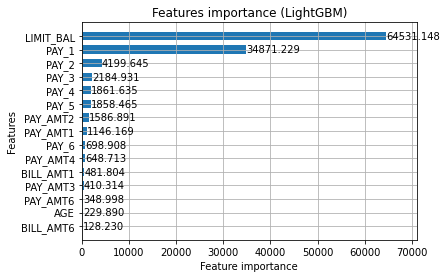

In [57]:
# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
plt.show()

We notice that the synthetic feature `LIMIT_BAL` appears as the most important feature in this model although it has no predictive power for an entire demographic segment in the data. 

In [27]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "-----": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(balanced_accuracy_score, y_true, x, sensitive_features=group).difference(method='between_groups'), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(roc_auc_score, y_true, x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [60]:
models_dict = {"Unmitigated": (test_preds, test_scores)}
y_true = Y_test
group = A_str_test
#get_metrics_df(models_dict, Y_test, A_str_test)

metrics_dict = {
    "Overall selection rate": (
        lambda x: selection_rate(y_true, x), True),
    "Demographic parity difference": (
        lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
    "Demographic parity ratio": (
        lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
    "-----": (lambda x: "", True),
    "Overall balanced error rate": (
        lambda x: 1-balanced_accuracy_score(y_true, x), True),
    "Balanced error rate difference": (
        lambda x: MetricFrame(balanced_accuracy_score, y_true, x, sensitive_features=group).difference(method='between_groups'), True),
    "Equalized odds difference": (
        lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
    "------": (lambda x: "", True),
    "Overall AUC": (
        lambda x: roc_auc_score(y_true, x), False),
    "AUC difference": (
        lambda x: MetricFrame(roc_auc_score, y_true, x, sensitive_features=group).difference(method='between_groups'), False),
}

df_dict = {}
for metric_name, (metric_func, use_preds) in metrics_dict.items():
    df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                            for model_name, (preds, scores) in models_dict.items()]
pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

,Unmitigated
Overall selection rate,0.268111
Demographic parity difference,0.0511053
Demographic parity ratio,0.8225
-----,
Overall balanced error rate,0.220682
Balanced error rate difference,0.175789
Equalized odds difference,0.342283
------,
Overall AUC,0.851931
AUC difference,0.189712


We calculate several performance and disparity metrics below:

In [28]:
# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated
Overall selection rate,0.268111
Demographic parity difference,0.0511053
Demographic parity ratio,0.8225
-----,
Overall balanced error rate,0.220682
Balanced error rate difference,0.175789
Equalized odds difference,0.342283
------,
Overall AUC,0.851931
AUC difference,0.189712


### Overall Selection Rate

In [102]:
aux_tab = pd.DataFrame(list(zip(Y_test,test_preds,A_str_test)),columns = ['y_test','pred','sex'])
#total = aux_tab[(aux_tab['y_test'] == 1)]
pd.crosstab(aux_tab.y_test,aux_tab.pred)

#(1013 + 1400)/(591 + 5996 + 1013 + 1400)

#Overall Selection Rate
selected = aux_tab['pred'] == 1
s_w = np.ones(len(selected))

selected.sum()/s_w.sum()

0.26811111111111113

### Demographic parity difference

In [108]:
aux_tab = pd.DataFrame(list(zip(Y_test,test_preds,A_str_test)),columns = ['y_test','pred','sex'])
#total = aux_tab[(aux_tab['y_test'] == 1)]
aux_tab_f = aux_tab[aux_tab['sex'] == 'female']
aux_tab_m = aux_tab[aux_tab['sex'] == 'male']

f_dp = selection_rate(aux_tab_f['y_test'], aux_tab_f['pred'])
m_dp = selection_rate(aux_tab_m['y_test'], aux_tab_m['pred'])

print('female:',f_dp)
print('male:',m_dp)

print('dpd:',f_dp - m_dp)

female: 0.28791727140783746
male: 0.2368119266055046
dpd: 0.051105344802332864


### Demographic parity Ratio

In [113]:
aux_tab = pd.DataFrame(list(zip(Y_test,test_preds,A_str_test)),columns = ['y_test','pred','sex'])
#total = aux_tab[(aux_tab['y_test'] == 1)]
aux_tab_f = aux_tab[aux_tab['sex'] == 'female']
aux_tab_m = aux_tab[aux_tab['sex'] == 'male']

f_dp = selection_rate(aux_tab_f['y_test'], aux_tab_f['pred'])
m_dp = selection_rate(aux_tab_m['y_test'], aux_tab_m['pred'])

print('female:',f_dp)
print('male:',m_dp)

print('dpr:',min([m_dp,f_dp]/max([m_dp,f_dp])))

female: 0.28791727140783746
male: 0.2368119266055046
dpr: 0.8224998988339894


### Overall balanced error rate

**Overall** Ballanced Error rate -> Without generating subgroups, just make:
- *1 - overall balanced accuracy*

### Balanced error rate difference

In [121]:
aux_tab = pd.DataFrame(list(zip(Y_test,test_preds,A_str_test)),columns = ['y_test','pred','sex'])
#total = aux_tab[(aux_tab['y_test'] == 1)]
aux_tab_f = aux_tab[aux_tab['sex'] == 'female']
aux_tab_m = aux_tab[aux_tab['sex'] == 'male']

f_bal_acc = balanced_accuracy_score(aux_tab_f['y_test'], aux_tab_f['pred'])
m_bal_acc = balanced_accuracy_score(aux_tab_m['y_test'], aux_tab_m['pred'])

print('female:',f_bal_acc)
print('male:',m_bal_acc)

print('dpd:',f_bal_acc - m_bal_acc)

# MetricFrame(balanced_accuracy_score, aux_tab['y_test'], aux_tab['pred'], sensitive_features=aux_tab['sex'])\
# .difference(method='between_groups')

female: 0.8538752913752914
male: 0.6780858293542882
dpd: 0.1757894620210032


### Equalized Odds Difference

In [145]:
def tpr(y_test,y_pred):
    tp = (y_test==1) & (y_pred == 1)
    fn = (y_test==1) & (y_pred == 0)
    r = tp.sum()/(tp.sum() + fn.sum())
    return r

def fpr(y_test,y_pred):
    fp = (y_test==0) & (y_pred == 1)
    tn = (y_test==0) & (y_pred == 0)
    r = fp.sum()/(fp.sum() + tn.sum())
    return r

aux_tab = pd.DataFrame(list(zip(Y_test,test_preds,A_str_test)),columns = ['y_test','pred','sex'])
#total = aux_tab[(aux_tab['y_test'] == 1)]
aux_tab_f = aux_tab[aux_tab['sex'] == 'female']
aux_tab_m = aux_tab[aux_tab['sex'] == 'male']

f_tpr = tpr(aux_tab_f['y_test'], aux_tab_f['pred'])
f_fpr = fpr(aux_tab_f['y_test'], aux_tab_f['pred'])

m_tpr = tpr(aux_tab_m['y_test'], aux_tab_m['pred'])
m_fpr = fpr(aux_tab_m['y_test'], aux_tab_m['pred'])

print('diff tpr:',abs(f_tpr - m_tpr))
print('diff fpr:',abs(f_fpr - m_fpr))

diff tpr: 0.3422827172827173
diff fpr: 0.009296206759288939


As the overall performance metric we use the _area under ROC curve_ (AUC), which is suited to classification problems with a large imbalance between positive and negative examples. For binary classifiers, this is the same as _balanced accuracy_.

As the fairness metric we use *equalized odds difference*, which quantifies the disparity in accuracy experienced by different demographics. Our goal is to assure that neither of the two groups (men vs women) has substantially larger false-positive rates or false-negative rates than the other group. The equalized odds difference is equal to the larger of the following two numbers: (1) the difference between false-positive rates of the two groups, (2) the difference between false-negative rates of the two groups.

The table above shows the overall AUC of 0.85 (based on continuous predictions) and the overall balanced error rate of 0.22 (based on 0/1 predictions). Both of these are satisfactory in our application context. However, there is a large disparity in accuracy rates (as indicated by the balanced error rate difference) and even larger when we consider the equalized-odds difference. As a sanity check, we also show the demographic parity ratio, whose level (slightly above 0.8) is considered satisfactory in this context.

## Mitigating Equalized Odds Difference with Postprocessing

We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [29]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds")

In [30]:
# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)

In [31]:
df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

In [32]:
postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'))

In [33]:
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

In [34]:
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.268111,0.225333
Demographic parity difference,0.0511053,0.0107842
Demographic parity ratio,0.8225,0.953504
-----,,
Overall balanced error rate,0.220682,0.323172
Balanced error rate difference,0.175789,0.00174642
Equalized odds difference,0.342283,0.00439333
------,,
Overall AUC,0.851931,0.676828
AUC difference,0.189712,0.00174642


The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

Below, we compare this model with the unmitigated `lightgbm` model using the Fairlearn dashboard. As the performance metric, we can select the balanced accuracy. The dashboard right now does not directly show the equalized odds difference, but a similar information is shown in the _Disparity in Accuracy_ view, where we can examine the difference between overprediction and underprediction rates of the two groups.

**Unmitigated Model vs ThresholdOptimizer: Dashboard Demo**

In [35]:
FairlearnDashboard(sensitive_features=A_str_test, sensitive_feature_names=['Sex'],
                   y_true=Y_test,
                   y_pred={"Unmitigated": test_preds,
                          "ThresholdOptimizer": postprocess_preds})

c:\users\mr saraivinha\documents\github\fairlearn\.env\lib\site-packages\fairlearn\widget\_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1…

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

In [36]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=41,
                   grid_limit=2)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


In [37]:
sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_] 

In [38]:
equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

In [39]:
# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

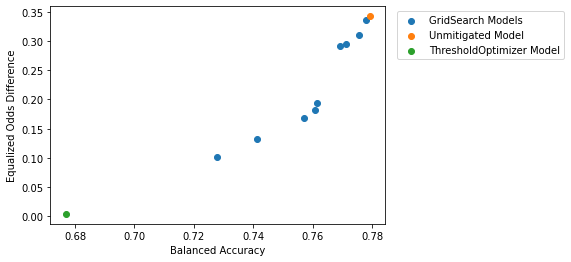

In [40]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

As intended, `GridSearch` models appear along the trade-off curve between the large balanced accuracy (but also large disparity), and low disparity (but worse balanced accuracy). This gives the data scientist a flexibility to select a model that fits the application context best.

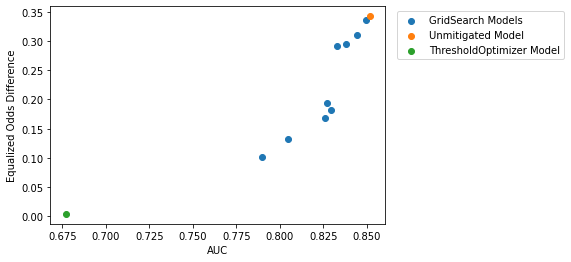

In [41]:
# Plot equalized odds difference vs AUC
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

Similarly, `GridSearch` models appear along the trade-off curve between AUC and equalized odds difference.

In [42]:
model_sweep_dict = {"GridSearch_{}".format(i): sweep_preds[i] for i in range(len(sweep_preds)) if non_dominated[i]}
model_sweep_dict.update({"Unmitigated": test_preds, "ThresholdOptimizer": postprocess_preds})

**Grid Search: Dashboard Demo**

We compare the `GridSearch` candidate models with the unmitigated `lightgbm` model and the `ThresholdOptimizer` model using the Fairlearn dashboard. We can select the balanced accuracy as the performance metric and examine the trade-off curve between balanced accuracy and the disparity in balanced accuracy.

In [43]:
FairlearnDashboard(sensitive_features=A_str_test, sensitive_feature_names=['Sex'],
                   y_true=Y_test,
                   y_pred=model_sweep_dict)

c:\users\mr saraivinha\documents\github\fairlearn\.env\lib\site-packages\fairlearn\widget\_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1…

### More References

https://arxiv.org/pdf/1803.02453.pdf

https://dzone.com/articles/machine-learning-models-bias-mitigation-strategies